# 소비자 데이터 기반 소비 예측 경진대회 EDA

https://dacon.io/competitions/official/235893/overview/description

안녕하세요! 소비자 데이터 기반 소비 예측 경진대회로 돌아온 데이콘 Basic 입니다!

이번 대회는 소비자 데이터를 통하여 소비량을 예측하는 대회입니다.

대회를 시작하기 앞서 어떤 데이터가 주어졌고 어떤 방식으로 활용할 수 있을지 데이터를 분석하고 시각화하며 인사이트를 얻어내는 작업이 필요합니다.

## 데이터 불러오기
먼저 주어진 데이터를 불러오고 확인합니다.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 
# error, warning 무시 --> 경고 끔
pd.set_option('mode.chained_assignment',  None)

In [ ]:
train = pd.read_csv('data/train.csv')  # 다운받은 csv를 pandas의 DataFrame 형식으로 불러옵니다.
train.head()

In [ ]:
train.shape # 데이터를 모양을 확인합니다.

데이터를 보아하니 10개의 열과 1253개의 행을 가진 데이터 입니다.

고유번호인 id를 제외하면 22가지의 피쳐와 1가지의 타겟이 존재합니다.

In [ ]:
train.info()

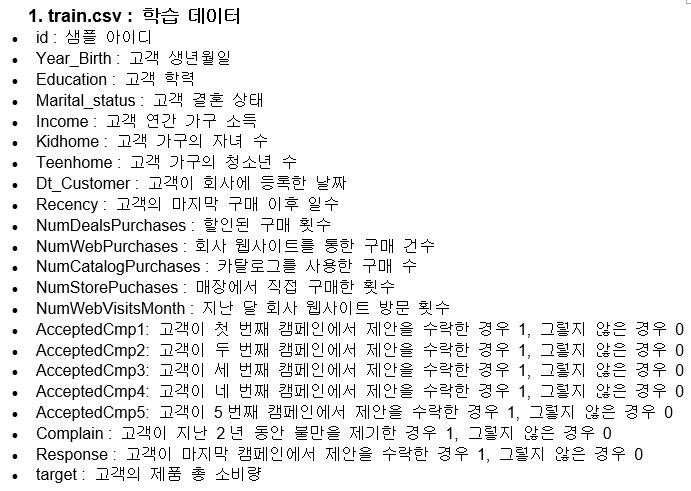

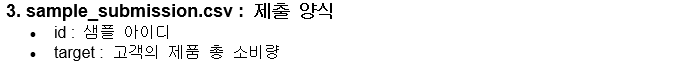

또한 데이터를 살펴보면,   
AcceptedCmp, Complain 그리고 Response는 int로 되어있지만 에/아니오 로 바이너리한 값을 가지고 있습니다.   
Education 와 marital_status는 범주형 변수인 것을 확인해볼 수 있습니다.   
고객이 회사에 등록한 날짜인 Dt_Customer는 문자열(string)로 되어있는 것을 확인할 수 있습니다.


## 결측치 확인

우선 결측치 (NA: Not Available) 처리부터 해 줄 것입니다.

결측치란 값이 누락된 데이터를 말합니다.

보다 정확한 분석을 하기 위해서는 데이터의 결측치를 확인하고 적절히 처리해주어야 합니다.

이번 데이터에 결측치가 있나 확인해볼까요?

In [ ]:
# 결측치 존재 여부를 확인해주는 함수
def check_missing_col(dataframe):
    missing_col = []
    counted_missing_col = 0
    for i, col in enumerate(dataframe.columns):
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼은: {col}입니다')
            print(f'해당 컬럼에 총 {missing_values}개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if counted_missing_col == 0:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(train)

결측치가 없는 깔끔한 데이터셋입니다!

결측치 처리는 넘어가도록 하겠습니다.

## 데이터 전처리

### 일자 분리

주어진 데이터를 살펴보면 Dt_Customer 문자열(string)로 되어있는 것을 확인하실 수 있습니다.

Dt_Customer 피쳐를 사용하고 분석하기 위해선 글자나 문자를 숫자로 바꿔주는 작업이 필요합니다.

이를 각각 년도, 월, 일로 나누어 숫자형으로 변환해 보겠습니다.

In [ ]:
def seperate_datetime(dataframe):
    year = []
    month = []
    day = []

    for date in dataframe.Dt_Customer:
        year_point, month_point, day_point = date.split('-') # - 기준으로 string을 나누고 list로 만듦 ex) '2016-04-01' -> ['2016', '04', '01']
        year.append(int(year_point))
        month.append(int(month_point))
        day.append(int(day_point))
    return year, month, day

day, month, year = seperate_datetime(train)
    
train['year'] = year
train['month'] = month
train['day'] = day

train.head()

년도, 월, 일이 전부 잘 분리되어 들어간게 보이시나요?

이제 사용할 필요 없는 중복된 Dt_Customer 열을 삭제해주겠습니다.

In [ ]:
train = train.drop('Dt_Customer', axis = 1)
train.shape ## (행, 열)

## 피쳐 타입 분리

피쳐를 범주형과 수치형으로 타입별로 나누어 분석해보겠습니다. 

우선 다음과 같이 컬럼을 나누어 주겠습니다.

In [ ]:
categorical = ['Education', 'Marital_Status', 'Kidhome', 'Teenhome', 
               'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 
               'Complain', 'Response']

quantitative = ['Year_Birth', 'Income', 'year',	'month', 'day', 'Recency', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

print('카테고리형(정성적) columns : {0} 개'.format(len(categorical)))
print('수치형(정량적) columns : {0} 개'.format(len(quantitative)))

### 범주형 데이터 탐색

그럼 범주형 11개 피쳐를 먼저 시각화 하여 데이터를 탐색해보도록 합시다!

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(20,15))
fig.suptitle('Distribution of customers per category', fontsize=40)

for ax, feature in zip(axes.flatten(), categorical):
    sns.countplot(data = train, x = feature, ax=ax)
plt.show()

그래프를 보면, 다음과 같이 인사이트를 도출 할 수 있습니다.

1. Marital_Status에서 'Alone', 'YOLO', 'Absurd'는 데이터가 극히 작고 Single에 범주에 포함되므로 single로 통합시켜 분석할 수도 있습니다.
2. Kidhome와 Teenhome에서 자녀 및 청소년을 2명둔 사람은 소수라고 볼 수 있습니다.
3. AcceptedCmp1~5에서 보면, 1의 데이터가 적으므로 켐페인에 참여한 사람은 소수라고 볼 수 있습니다.

### 수치형 데이터 탐색
이제 수치형 11개 피쳐를 시각화 하여 데이터를 탐색해보도록 합시다!

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(20,20))
fig.suptitle('Distribution of quantitative features', fontsize=40)
#plt.tight_layout()

for ax,feature in zip(axes.flatten(),quantitative):
    sns.histplot(data = train, x = feature, ax=ax, color='#f55354', edgecolor='#f15354')
plt.show()

그래프를 보면, 다음과 같이 인사이트를 도출 할 수 있습니다.

Year_Birth에서 1970 ~ 1980년생의 거래건수가 가장 많이 발생했다고 볼 수 있습니다.   
Income에서 30000~70000 사이 가구 소득의 거래건수가 가장 많았다고 볼 수 있습니다.   
year에서 13년도에 가장 거래건수가 많았다고 볼 수 있습니다.  
Year_Birth, income, NumDealsPurchases, NumWebPurchases, NumWebVisitsMonth에서 이상치 발생 가능성을 볼 수 있습니다.

### 이상치 찾기

이제 극단값을 찾도록 해보겠습니다.  
boxenplot을 이용해 시각화하여 이해를 돕겠습니다.

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(20,20))
fig.suptitle('Distribution of quantitative features', fontsize=40)
#plt.tight_layout()

for ax,feature in zip(axes.flatten(),quantitative):
    sns.boxenplot(data = train, x = feature, ax=ax, color='#f15354')
plt.show()

IQR을 이용하여 이상치의 최대 제한선을 구하고 그 사이 범위를 구해보겠습니다.

IQR 은 Interquartile range의 약자로써 사분위수의 상위 75% 지점의 값과 하위 25% 지점의 값 차이 (Q3 - Q1)를 의미합니다.

In [ ]:
from scipy import stats
def IQR(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 -(1.5 * IQR)
    upper_bound = Q3 +(1.5 * IQR)
    return lower_bound, upper_bound

outliers = train[quantitative].apply(lambda column: IQR(column))
print('Range of outliers by method')
outliers

그럼 이 데이터에서 날짜를 제외한 이상치 데이터가 몇개나 되는지 구해볼까요?

In [ ]:
def IQRsum(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 -(1.5 * IQR)
    upper_bound = Q3 +(1.5 * IQR)
    return ((column < lower_bound) | (column > upper_bound)).sum()

outliers = train[quantitative].drop(['year', 'month', 'day'], axis = 1).apply(lambda column: IQRsum(column))
print('Number of outliers by method')
outliers

할인된 구매 횟수인 'NumDealsPurchases' 에서 이상치가 46개로 많이 발생했다는 것을 알 수 있습니다.

## 상관관계 확인하기

피어슨 상관관계 분석 방법을 이용하여,

feature들 간의 상관관계를 히트맵을 그려 어떤 컬럼들이 높은 상관관계를 갖는지 알아보겠습니다.

In [ ]:
quantitative.append('target')

In [ ]:
# 수치형 데이터 상관관계 히트맵 시각화
train_corr = train[quantitative]
scaler= MinMaxScaler() 
train_corr[train_corr.columns] = scaler.fit_transform(train_corr[train_corr.columns])
corr28 = train_corr.corr(method= 'pearson')

plt.figure(figsize=(12,10))
sns.heatmap(data = corr28, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
plt.title('Correlation between features', fontsize=30)

feature가 많아서 헷갈리니 Target과의 관계만을 살펴보겠습니다.

In [ ]:
# Target과 피쳐들의 상관관계
s28 = corr28.unstack()
df_temp28 = pd.DataFrame(s28['target'].sort_values(ascending=False), columns=['target'])
df_temp28.style.background_gradient(cmap='viridis')

우리가 가장 관심있는 것은 총 제품 소비량와 어떤 컬럼이 가장 상관관계가 높은가 입니다.

그래프를 보니 NumCatalogPurchasest가 가장 높은 양의 상관관계가 있는것으로 나타났네요!

이는 카탈로그를 사용한 구매 수 많을수록 제품 소비량이 늘어나는 것으로 해석할 수 있겠습니다.

또한 상관계수가 0.3 이상이면 유의미한 양의 상관관계를 가진다고 해석할 수 있습니다.

그러므로 Income, NumStorePurchases, NumWebPurchases피쳐들도 상관계수가 0.3 이상이기 때문에 고객의 수입,  매장에서 직접 구매한 횟수, 웹사이트를 통한 구매 건수가 많을 수록 총 제품 소비량이 늘어난다는 결론을 도출 할 수 있겠습니다.



여러분은 어떤 인사이트를 얻으셨나요?

이번 EDA를 통해 어떤 방식으로 분석을 진행해야겠다는 자그마한 인사이트를 얻으셨으면 좋겠습니다.

여러분도 여러분만의 EDA를 진행하시고 코드공유에 올려주세요!

좋아요와 댓글을 합산하여 가장 높은 점수를 얻으신 분께 데이콘 후드가 제공됩니다!